In [1]:
import numpy as np
import trimesh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh = trimesh.load("models/soda_can.glb", force="mesh")
mesh

<trimesh.Trimesh(vertices.shape=(648, 3), faces.shape=(980, 3))>

In [7]:
mesh.vertices.view(np.ndarray)

array([[ 0.        , -4.09881889, -2.32685   ],
       [ 0.        ,  3.36951479, -2.32685   ],
       [ 0.48377539,  3.36951479, -2.27600835],
       ...,
       [-1.58677213, -4.35759303,  0.16678861],
       [-1.51743201, -4.35759303,  0.49303624],
       [-1.38175331, -4.35759303,  0.79776052]])

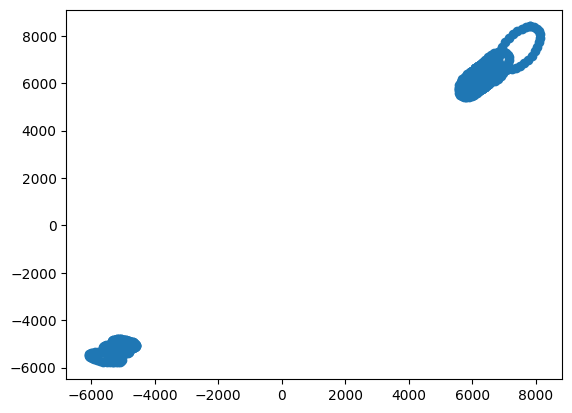

In [18]:
from projection import euler_to_rotation_matrix
def project_3d_to_2d(points_3d, R, t, K):
    # Create a transformation matrix
    transformation_matrix = np.hstack((R, t))

    # Convert points to homogeneous coordinates
    points_3d_homo = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))

    # Project the points to 2D
    points_2d = np.dot(K, np.dot(transformation_matrix, points_3d_homo.T)).T
    points_2d = (points_2d / points_2d[:, 2, None])[
        :, :2
    ]  # Convert to inhomogeneous coordinates

    return points_2d


# Camera properties
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])  # Intrinsic matrix (fx, fy, cx, cy)
R = euler_to_rotation_matrix(1.5, 0, 0) # np.eye(3)  # Identity matrix for rotation (no rotation)
t = np.array([[30, 30, 0]]).T  # Translation (keeping cylinder 5 units in front of the camera)

vert2d = project_3d_to_2d(mesh.vertices.view(np.ndarray), R, t, K)
plt.scatter(*vert2d.T)

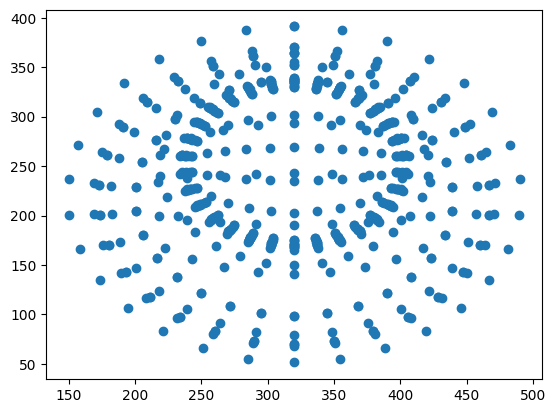

In [9]:
plt.scatter(*vert2d.T)

In [19]:
mesh.show()

In [5]:
mesh.

<trimesh.Trimesh(vertices.shape=(648, 3), faces.shape=(980, 3))>

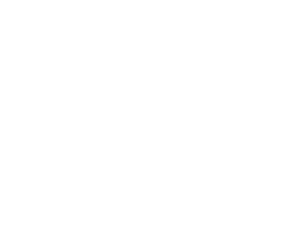

In [4]:

def perspective_projection(mesh, camera_pose, focal_length=1000, img_size=(640, 480)):
    """ Apply perspective projection to the 3D mesh. """
    # Create a PyRender scene
    scene = pyrender.Scene()
    camera = pyrender.IntrinsicsCamera(fx=focal_length, fy=focal_length, 
                                       cx=img_size[0]/2, cy=img_size[1]/2)
    scene.add(camera, pose=camera_pose)
    mesh = pyrender.Mesh.from_trimesh(mesh)
    scene.add(mesh)

    # Use an offscreen renderer to get the projected points
    renderer = pyrender.OffscreenRenderer(*img_size)
    color, _ = renderer.render(scene)
    return color

def plot_2d_projection(image):
    """ Plot the 2D projection image. """
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Replace 'path_to_your_model.ext' with the path to your 3D model file
# mesh = load_mesh('path_to_your_model.ext')

# Define camera pose (position and orientation)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, -3],  # Adjust Y to move camera up or down
    [0, 0, 1, -15],  # Adjust Z to move camera closer or further
    [0, 0, 0, 1]
])

# Perform the perspective projection
projected_image = perspective_projection(mesh, camera_pose)
plot_2d_projection(projected_image)


In [7]:
%%timeit
projected_image = perspective_projection(mesh, camera_pose)

1.14 s ± 260 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:

def load_mesh(filename):
    """ Load the mesh file. """
    return o3d.io.read_triangle_mesh(filename)

def create_view_control(width, height):
    """ Create a view control with specified width and height. """
    view_control = o3d.visualization.ViewControl()
    #view_control.set_lookat([0, 0, 0])  # Center of the view
    #view_control.set_up([0, 1, 0])      # Up direction
    #view_control.set_front([0, 0, 1])   # Direction the camera is looking at
    view_control.set_zoom(0.5)          # Zoom level
    # view_control.set_window_size(width, height)
    return view_control

def render_image(mesh, camera_position, image_size=(640, 480)):
    """ Render the mesh from a given camera position. """
    # Set up the visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=image_size[0], height=image_size[1])
    vis.add_geometry(mesh)
    
    ctr = vis.get_view_control()
    cam_params = ctr.convert_to_pinhole_camera_parameters()
    cam_params.extrinsic = np.linalg.inv(o3d.camera.PinholeCameraParameters.create_lookat(
        lookat=lookat_point,
        up=camera_up,
        front=camera_position
    ))
    ctr.convert_from_pinhole_camera_parameters(cam_params)

    # Capture the image
    vis.poll_events()
    vis.update_renderer()
    image = vis.capture_screen_float_buffer()
    vis.destroy_window()
    return np.asarray(image)

def plot_2d_projection(image):
    """ Plot the 2D projection image. """
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define the camera position
camera_position = [0, -33, -15]  # Adjust as needed

# Render the image
rendered_image = render_image(load_mesh("models/soda_can.glb"), camera_position)

plot_2d_projection(rendered_image)


AttributeError: type object 'open3d.cpu.pybind.camera.PinholeCameraParameters' has no attribute 'create_lookat'

In [28]:

# Get a scene object from the mesh, which will have automatically generated camera positions
scene = mesh.scene()

# a 45 degree homogeneous rotation matrix around
# the Y axis at the scene centroid
rotate = trimesh.transformations.rotation_matrix(
    angle=np.radians(30.0), direction=[1, 0, 0], point=scene.centroid
)

for i in range(2):
    # trimesh.constants.log.info(f"Saving image {i}")

    # rotate the camera view transform
    camera_old, _geometry = scene.graph[scene.camera.name]
    camera_new = np.dot(rotate, camera_old)

    # apply the new transform
    scene.graph[scene.camera.name] = camera_new

    # saving an image requires an opengl context, so if -nw
    # is passed don't save the image
    file_name = "output/render_" + str(i) + ".png"
    # save a render of the object as a png
    png = scene.save_image(resolution=[1920, 1080], visible=True)
    with open(file_name, "wb") as f:
        f.write(png)
        f.close()

In [29]:
help(scene.save_image)

Help on method save_image in module trimesh.scene.scene:

save_image(resolution=None, **kwargs) method of trimesh.scene.scene.Scene instance
    Get a PNG image of a scene.
    
    Parameters
    -----------
    resolution : (2,) int
      Resolution to render image
    **kwargs
      Passed to SceneViewer constructor
    
    Returns
    -----------
    png : bytes
      Render of scene as a PNG



In [33]:
import moderngl
import numpy as np
from PIL import Image

# Create a standalone ModernGL context (offscreen rendering)
ctx = moderngl.create_standalone_context()

# Define a simple square as vertices
vertices = np.array([
    -1.0, -1.0,
    1.0, -1.0,
    -1.0, 1.0,
    1.0, 1.0,
])

# Load the vertices into a ModernGL buffer
vbo = ctx.buffer(vertices.astype('f4').tobytes())

# Create a simple vertex shader
prog = ctx.program(
    vertex_shader='''
    #version 330
    in vec2 in_vert;
    void main() {
        gl_Position = vec4(in_vert, 0.0, 1.0);
    }
    ''',
    fragment_shader='''
    #version 330
    out vec4 f_color;
    void main() {
        f_color = vec4(0.3, 0.5, 1.0, 1.0);
    }
    ''',
)

# Configure the vertex array
vao = ctx.simple_vertex_array(prog, vbo, 'in_vert')

# Render to an offscreen buffer
fbo = ctx.simple_framebuffer((512, 512))
fbo.use()
fbo.clear(0.0, 0.0, 0.0, 1.0)
vao.render(moderngl.TRIANGLE_STRIP)

# Read the pixel data
data = fbo.read(components=3)
image = Image.frombytes('RGB', fbo.size, data)
image = image.transpose(Image.FLIP_TOP_BOTTOM)
image.save('output.png')


C:\Users\bobla\AppData\Local\Temp\ipykernel_23088\3113791221.py:49: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  image = image.transpose(Image.FLIP_TOP_BOTTOM)


In [36]:
faces

array([[  0,   1,   2],
       [  0,   2,   3],
       [  3,   2,   4],
       ...,
       [639, 646, 645],
       [640, 641, 647],
       [640, 647, 646]], dtype=int64)

In [37]:

# Extract vertex data
vertices = mesh.vertices.view(np.ndarray)
faces = mesh.faces.view(np.ndarray)

# Flatten the array and convert to bytes
vertex_data = vertices.flatten().astype('f4').tobytes()
index_data = faces.flatten().astype('i4').tobytes()

import moderngl
from PIL import Image

# Create a ModernGL context
ctx = moderngl.create_standalone_context()

# Create a buffer for vertex positions
vbo = ctx.buffer(vertex_data)

# Create a buffer for indices if the mesh is indexed
ibo = ctx.buffer(index_data)

# Define shaders. These will need to be adjusted to match the attributes of your mesh and desired visual output.
prog = ctx.program(
    vertex_shader='''
        #version 330
        in vec3 in_vert;
        void main() {
            gl_Position = vec4(in_vert, 1.0);
        }
    ''',
    fragment_shader='''
        #version 330
        out vec4 f_color;
        void main() {
            f_color = vec4(1.0, 0.5, 0.5, 1.0);
        }
    ''',
)

# Define the vertex array object (VAO) and associate it with the shader program and buffers
vao = ctx.vertex_array(prog, [(vbo, '3f', 'in_vert')], ibo)

# Define a framebuffer for offscreen rendering
fbo = ctx.framebuffer(
    color_attachments=[ctx.texture((800, 600), 4)]
)

# Render to the framebuffer
fbo.use()
ctx.clear()
vao.render(moderngl.TRIANGLES)

# Read the pixel data
data = fbo.read(components=3)
image = Image.frombytes('RGB', fbo.size, data)
image = image.transpose(Image.FLIP_TOP_BOTTOM)
image.show()  # or image.save('output.png')


C:\Users\bobla\AppData\Local\Temp\ipykernel_23088\2489489199.py:55: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  image = image.transpose(Image.FLIP_TOP_BOTTOM)


In [42]:
import trimesh
import numpy as np
import moderngl
from PIL import Image

# Load the mesh using trimesh
mesh = trimesh.load('models/soda_can.glb', process=False, force="mesh")

# Extract vertex positions and normals
vertices = np.array(mesh.vertices, dtype='f4').flatten()
normals = np.array(mesh.vertex_normals, dtype='f4').flatten()

# Extract the faces and create an indices array
indices = np.array(mesh.faces, dtype='u4').flatten()

# Create a ModernGL context for offscreen rendering
ctx = moderngl.create_standalone_context()

# Vertex and fragment shaders
vertex_shader = '''
    #version 330
    in vec3 in_vert;
    in vec3 in_norm;
    uniform mat4 model;
    uniform mat4 view;
    uniform mat4 projection;
    out vec3 v_norm;
    void main() {
        gl_Position = projection * view * model * vec4(in_vert, 1.0);
        v_norm = in_norm;
    }
'''

fragment_shader = '''
    #version 330
    in vec3 v_norm;
    uniform vec3 light_dir = normalize(vec3(1.0, 1.0, 1.0)); // light direction
    out vec4 frag_color;
    void main() {
        float lum = max(dot(normalize(v_norm), light_dir), 0.0);
        frag_color = vec4(lum, lum, lum, 1.0); // shade of gray based on luminance
    }
'''

# Compile the program with shaders
prog = ctx.program(vertex_shader=vertex_shader, fragment_shader=fragment_shader)

# Set up the buffers for the vertex data
vbo = ctx.buffer(vertices.tobytes())
nbo = ctx.buffer(normals.tobytes())
ibo = ctx.buffer(indices.tobytes())

# Define the VAO and associate it with the shader program and buffers
vao = ctx.vertex_array(
    prog,
    [
        (vbo, '3f', 'in_vert'),
        (nbo, '3f', 'in_norm')
    ],
    ibo,
)

# Set up framebuffer for offscreen rendering
fbo = ctx.framebuffer(color_attachments=[ctx.texture((800, 600), 4)])
fbo.use()
ctx.clear(0.1, 0.1, 0.1, 1.0)  # Clear the framebuffer with a gray color

# Define the model, view, and projection matrices
# Adjust these to fit the object within the camera's frustum and to scale it appropriately
model = np.eye(4, dtype='f4')  # Identity matrix for the model

def look_at(eye, target, up):
    # Compute the forward, right, and up vectors
    forward = np.array(target, float) - np.array(eye, float)
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    up = np.cross(right, forward)
    up /= np.linalg.norm(up)

    # Construct the view matrix
    view_matrix = np.eye(4)
    view_matrix[:3, :3] = np.stack([-right, up, forward])
    view_matrix[:3, 3] = np.dot(-np.stack([eye]), np.stack([-right, up, forward]))

    return view_matrix

def perspective(fov, aspect, near, far):
    # Generate a perspective projection matrix
    f = 1.0 / np.tan(fov / 2.0)
    perspective_matrix = np.zeros((4, 4))
    perspective_matrix[0, 0] = f / aspect
    perspective_matrix[1, 1] = f
    perspective_matrix[2, 2] = (far + near) / (near - far)
    perspective_matrix[3, 2] = (2.0 * far * near) / (near - far)
    perspective_matrix[2, 3] = -1.0
    return perspective_matrix

# Assuming the eye position (camera position), the target (look at point), and the up vector
eye = [0, 0, 3]  # Example camera position
target = [0, 0, 0]  # Looking at the origin
up = [0, 1, 0]  # Y is up

# Create the view and projection matrices
view = look_at(eye, target, up)
projection = perspective(np.radians(45), 800 / 600, 0.1, 1000.0)


# Write the matrices to the shader program
prog['model'].write(model.tobytes())
prog['view'].write(view.astype('f4').tobytes())
prog['projection'].write(projection.astype('f4').tobytes())

# Render the object
vao.render(moderngl.TRIANGLES)

# Read pixels from the framebuffer
data = fbo.read(components=3)
image = Image.frombytes('RGB', fbo.size, data)
image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Save or display the image
image.save('rendered_soda_can.png')
# image.show()


C:\Users\bobla\AppData\Local\Temp\ipykernel_23088\1747252442.py:120: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  image = image.transpose(Image.FLIP_TOP_BOTTOM)


In [43]:
import numpy as np
from plotoptix import TkOptiX

n = 1000000                                  # 1M points, better not try this with matplotlib
xyz = 3 * (np.random.random((n, 3)) - 0.5)   # random 3D positions
r = 0.02 * np.random.random(n) + 0.002       # random radii

plot = TkOptiX()
plot.set_data("my plot", xyz, r=r)
plot.show()

[ERROR] (MainThread) Initial setup failed, see errors above.
[ERROR] (MainThread) Geometry setup failed.
[ERROR] (MainThread) Camera setup failed.
Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\plotoptix\npoptix.py", line 428, in run
    assert self._is_scene_created, "Scene is not ready, see initialization messages."
AssertionError: Scene is not ready, see initialization messages.
